In [ ]:
import tensorflow as tf
from tensorflow import keras
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Data

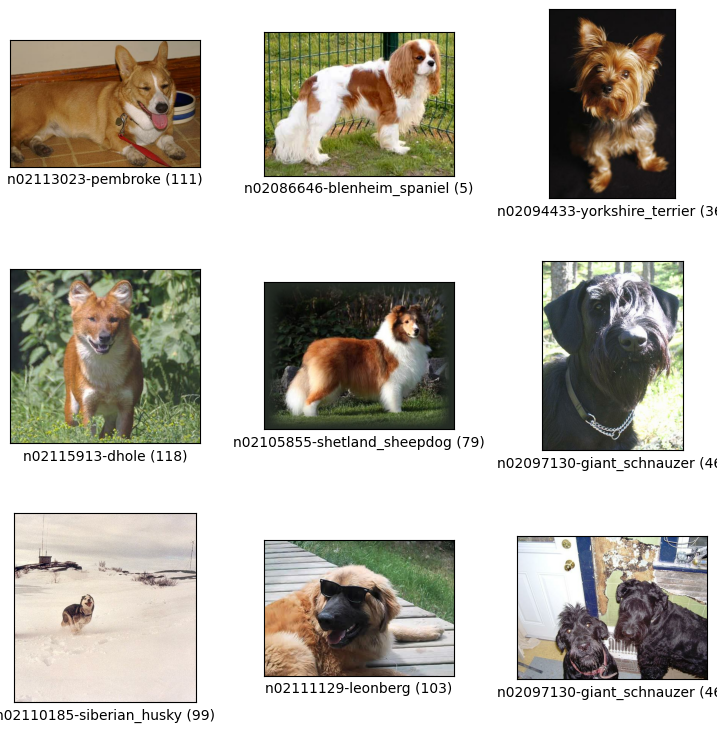

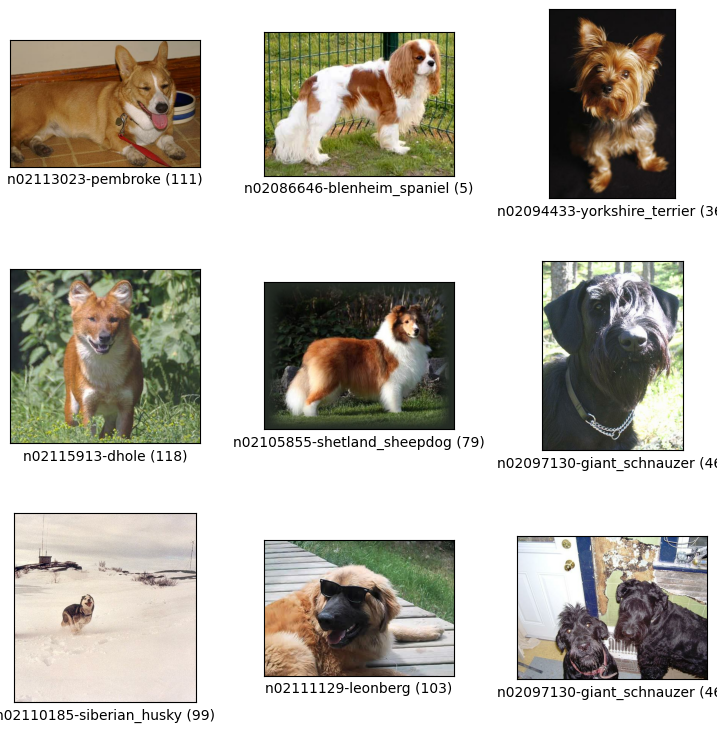

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
tfds.show_examples(ds_train, ds_info)

In [ ]:
class_names = ds_info.features['label'].names
print(class_names)

# Augmentation Function

Mixup, Cutmix function

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)

    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)

    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)

    return mixed_img

def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b

    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

preprocess & aug function

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(
    ds, is_test=False,
    batch_size=16,
    with_aug=False,
    with_cutmix=False,
    with_mixup=False
):

    #기본 전처리
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=2
    )

    # Augmentation
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )

    # Batch
    ds = ds.batch(batch_size)

    # CutMix, MixUp, 또는 OneHot 중 하나만 적용
    if not is_test:
        if with_cutmix:
            ds = ds.map(cutmix, num_parallel_calls=2)
        elif with_mixup:
            ds = ds.map(mixup, num_parallel_calls=2)
        else:
            ds = ds.map(onehot, num_parallel_calls=2)
    else:
        ds = ds.map(onehot, num_parallel_calls=2)

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

## Cutmix, Mixup 함수 동작 확인


In [ ]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다.
for i, (image, label) in enumerate(ds_train.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

cutmix

In [ ]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

cutmix_image = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
cutmix_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120)

plt.title("CutMix Example")
plt.imshow(cutmix_image)
plt.axis("off")
plt.show()

mixup

In [ ]:
mixup_image, mixup_label = mixup_2_images(image_a, image_b, label_a, label_b)

plt.title("MixUp Example")
plt.imshow(mixup_image)
plt.axis("off")
plt.show()

# Model

build model function

In [ ]:
num_classes = ds_info.features["label"].num_classes

def build_resnet50_model(name, input_shape=(224, 224, 3), num_classes=120):
    base_model = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )
    model = keras.models.Sequential([
        base_model,
        keras.layers.Dense(num_classes, activation='softmax')
    ], name=name)
    return model

##  train

ready for train

In [ ]:
%cd '/content/drive/MyDrive/Colab Notebooks/AIFFEL/DeepDive'

EPOCH = 75

/content/drive/MyDrive/Colab Notebooks/AIFFEL/DeepDive


In [ ]:
import pandas as pd

def save_history_to_csv(history, filename="history.csv"):
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(filename, index=False)

# 체크포인트 콜백 생성
def get_checkpoint_cb(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=f"{model_name}_best.weights.h5",
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

#모델 생성, 데이터 전처리, 컴파일, 학습
def train_resnet_model(
    model_name,
    ds_train,
    with_aug=False,
    with_mixup=False,
    with_cutmix=False,
    epochs=25,
    batch_size=16,
    num_classes=120
):
    # 모델 정의
    model = build_resnet50_model(model_name, num_classes=num_classes)

    # 체크포인트 콜백
    checkpoint_cb = get_checkpoint_cb(model_name)

    # 학습을 위한 train, validation split
    ds_train = ds_train.shuffle(12000, seed=42)
    train_size = int(0.8 * ds_info.splits['train'].num_examples)
    ds_train_sub = ds_train.take(train_size)
    ds_val_sub = ds_train.skip(train_size)

    ds_train_proc = apply_normalize_on_dataset(
        ds_train, with_aug=with_aug, with_mixup=with_mixup, batch_size=batch_size
    )
    ds_val_proc = apply_normalize_on_dataset(
        ds_val_sub, is_test=True, batch_size=batch_size
    )

    # 컴파일
    model.compile(
            loss='categorical_crossentropy',
            optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
            metrics=[
                'accuracy',
                keras.metrics.F1Score(average="micro", name="f1_score")
            ]
        )

    # 훈련
    history = model.fit(
        ds_train_proc,
        steps_per_epoch=int(train_size/ batch_size),
        validation_steps=int((ds_info.splits['train'].num_examples - train_size) / batch_size),
        validation_data=ds_val_proc,
        epochs=epochs,
        callbacks=[checkpoint_cb],
        verbose=1
    )

    # 히스토리 저장
    save_history_to_csv(history, f"{model_name}_history.csv")

    # 베스트모델 로드
    model.load_weights(f"{model_name}_best.weights.h5")

    return model, history


baseline model

In [ ]:
model_base_resnet50, history_base_resnet50 = train_resnet_model(
    model_name="base_resnet50",
    ds_train=ds_train,
    with_aug=False,
    with_mixup=False,
    with_cutmix=False,
    epochs=EPOCH,
    batch_size=16,
    num_classes=num_classes
)

Epoch 1/75
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2409 - f1_score: 0.2409 - loss: 3.4537
Epoch 1: val_loss improved from inf to 4.74929, saving model to base_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.2411 - f1_score: 0.2411 - loss: 3.4521 - val_accuracy: 0.0317 - val_f1_score: 0.0317 - val_loss: 4.7493
Epoch 2/75
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6758 - f1_score: 0.6758 - loss: 1.1543
Epoch 2: val_loss improved from 4.74929 to 0.51140, saving model to base_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - accuracy: 0.6760 - f1_score: 0.6760 - loss: 1.1538 - val_accuracy: 0.8708 - val_f1_score: 0.8708 - val_loss: 0.5114
Epoch 3/75
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8002 - f1_score: 0.8002 - loss: 0.7051
Epoch 3: val_loss improved from 0.51140 to 0.25126, saving model to base_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8002 - f1_sco

base aug model

In [ ]:
model_base_aug_resnet50, history_base_aug_resnet50 = train_resnet_model(
    model_name="base_aug_resnet50",
    ds_train=ds_train,
    with_aug=True,
    with_mixup=False,
    with_cutmix=False,
    epochs=EPOCH,
    batch_size=16,
    num_classes=num_classes
)

Epoch 1/75
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2357 - f1_score: 0.2357 - loss: 3.4293
Epoch 1: val_loss improved from inf to 4.68235, saving model to base_aug_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.2359 - f1_score: 0.2359 - loss: 3.4277 - val_accuracy: 0.0538 - val_f1_score: 0.0537 - val_loss: 4.6824
Epoch 2/75
599/600 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6364 - f1_score: 0.6364 - loss: 1.2929
Epoch 2: val_loss improved from 4.68235 to 1.14606, saving model to base_aug_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.6365 - f1_score: 0.6365 - loss: 1.2924 - val_accuracy: 0.6642 - val_f1_score: 0.6642 - val_loss: 1.1461
Epoch 3/75
600/600 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7386 - f1_score: 0.7386 - loss: 0.8939
Epoch 3: val_loss improved from 1.14606 to 0.51093, saving model to base_aug_resnet50_best.weights.h5
600/600 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.7

Cutmix aug model

In [ ]:
model_cutmix_aug_resnet50, history_cutmix_aug_resnet50 = train_resnet_model(
    model_name="cutmix_aug_resnet50",
    ds_train=ds_train,
    with_aug=False,
    with_mixup=False,
    with_cutmix=True,
    epochs=EPOCH,
    batch_size=16,
    num_classes=num_classes
)

mixup aug model

In [ ]:
model_mixup_aug_resnet50, history_mixup_aug_resnet50 = train_resnet_model(
    model_name="mixup_aug_resnet50",
    ds_train=ds_train,
    with_aug=False,
    with_mixup=True,
    with_cutmix=False,
    epochs=EPOCH,
    batch_size=16,
    num_classes=num_classes
)

base+cutmix model

In [ ]:
model_baseaug_mixup_resnet50, history_baseaug_mixup_resnet50 = train_resnet_model(
    model_name="baseaug_mixup_resnet50",
    ds_train=ds_train,
    with_aug=True,
    with_mixup=True,
    with_cutmix=False,
    epochs=EPOCH,
    batch_size=16,
    num_classes=num_classes
)

base+mixup model

In [ ]:
model_baseaug_cutmix_resnet50, history_baseaug_cutmix_resnet50 = train_resnet_model(
    model_name="baseaug_mixup_resnet50",
    ds_train=ds_train,
    with_aug=True,
    with_mixup=False,
    with_cutmix=True,
    epochs=EPOCH,
    batch_size=16,
    num_classes=num_classes
)

# Plot History & Test Result

plot & summarize function

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history_list, model_list):
    metrics = ['accuracy', 'val_accuracy', 'f1_score', 'val_f1_score', 'loss', 'val_loss']
    titles = {
        'accuracy': 'Train Accuracy',
        'val_accuracy': 'Validation Accuracy',
        'f1_score': 'Train F1 Score',
        'val_f1_score': 'Validation F1 Score',
        'loss': 'Train Loss',
        'val_loss': 'Validation Loss'
    }

    n_rows, n_cols = 3, 2
    plt.figure(figsize=(18, 10))

    for idx, metric in enumerate(metrics):
        plt.subplot(n_rows, n_cols, idx + 1)
        for history, model_name in zip(history_list, model_list):
            if metric in history.history:
                plt.plot(history.history[metric], label=model_name)
        plt.title(titles[metric])
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()


def summarize_bestmodel_metrics(history_list, model_list):
    summary = {
        "Model": [],
        "Best Epoch (Val Loss)": [],
        "Val Accuracy": [],
        "Val F1 Score": [],
        "Val Loss": [],
    }

    for model_name, history in zip(model_list, history_list):
        hist = history.history
        val_acc = hist.get("val_accuracy", [])
        val_f1 = hist.get("val_f1_score", [])
        val_loss = hist.get("val_loss", [])

        if val_loss:
            best_epoch = int(np.argmin(val_loss))
            summary["Model"].append(model_name)
            summary["Best Epoch (Val Loss)"].append(best_epoch + 1)  # 1에폭부터 시작
            summary["Val Accuracy"].append(f"{val_acc[best_epoch]:.4f}" if val_acc else "-")
            summary["Val F1 Score"].append(f"{val_f1[best_epoch]:.4f}" if val_f1 else "-")
            summary["Val Loss"].append(f"{val_loss[best_epoch]:.4f}")
        else:
            summary["Model"].append(model_name)
            summary["Best Epoch (Val Loss)"].append("-")
            summary["Val Accuracy"].append("-")
            summary["Val F1 Score"].append("-")
            summary["Val Loss"].append("-")

    return pd.DataFrame(summary)


def summarize_test_result(best_models, model_names, ds_test_proc, num_classes=120):
    records = []
    ds_test_proc = apply_normalize_on_dataset(ds_test_proc, is_test=True, batch_size= 16)

    for model, name in zip(best_models, model_names):
        # 정확도, f1 평가
        loss, acc, f1 = model.evaluate(ds_test_proc, verbose=0)

        # top-k error
        y_true = []
        y_pred = []

        for x_batch, y_batch in ds_test_proc:
            preds = model.predict(x_batch, verbose=0)
            y_pred.append(preds)
            y_true.append(y_batch.numpy())

        y_true = np.concatenate(y_true, axis=0)
        y_pred = np.concatenate(y_pred, axis=0)

        # top-1, top-5 accuracy  >  error
        top1_err = 1 - tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=1).numpy().mean()
        top5_err = 1 - tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5).numpy().mean()

        records.append({
            "Model": name,
            "Test Accuracy": f"{acc:.4f}",
            "Test Loss": f"{loss:.4f}",
            "Test F1 Score(micro)": f"{f1:.4f}",
            "Top-1 Error": f"{top1_err:.4f}",
            "Top-5 Error": f"{top5_err:.4f}"
        })

    return pd.DataFrame(records)


In [ ]:
history_list=[
    history_base_resnet50,
    history_cutmix_aug_resnet50,
    history_mixup_aug_resnet50,
    history_baseaug_mixup_resnet50,
    history_baseaug_cutmix_resnet50,
]
modelname_list=[
    "Baseline",
    "CutMix",
    "MixUp",
    "Base + MixUp",
    "Base + CutMix",
]
best_models  =[
    model_base_resnet50,
    model_cutmix_aug_resnet50,
    model_mixup_aug_resnet50,
    model_baseaug_mixup_resnet50,
    model_baseaug_cutmix_resnet50
]

plot history

In [ ]:
plot_history(history_list, modelname_list)

train result to table

In [ ]:
df_best_summary = summarize_bestmodel_metrics(history_list, model_list)
display(df_best_summary)

test result to table

In [ ]:
df_result = summarize_test_result(
    best_models,
    model_names=modelname_list,
    ds_test_proc=ds_test,
    num_classes=120
)

from IPython.display import display
display(df_result)

# Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, ds_test_proc, ds_info, normalize='true'):
    ds_test_proc = apply_normalize_on_dataset(ds_test_proc, is_test=True, batch_size= 16)
    # 예측값 및 정답 수집
    y_true = []
    y_pred = []
    class_names = ds_info.features['label'].names

    for x_batch, y_batch in ds_test_proc:
        preds = model.predict(x_batch, verbose=0)
        y_pred_batch = np.argmax(preds, axis=1)

        if len(y_batch.shape) > 1 and y_batch.shape[1] > 1:
            y_true_batch = np.argmax(y_batch.numpy(), axis=1)
        else:
            y_true_batch = y_batch.numpy()

        y_true.extend(y_true_batch)
        y_pred.extend(y_pred_batch)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Confusion Matrix 계산
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)

    # 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix" + (f" (Normalized: {normalize})" if normalize else ""))
    plt.tight_layout()
    plt.show()

    return cm


In [ ]:
cm = plot_confusion_matrix(model_base_resnet50, ds_test, ds_info, normalize='true')